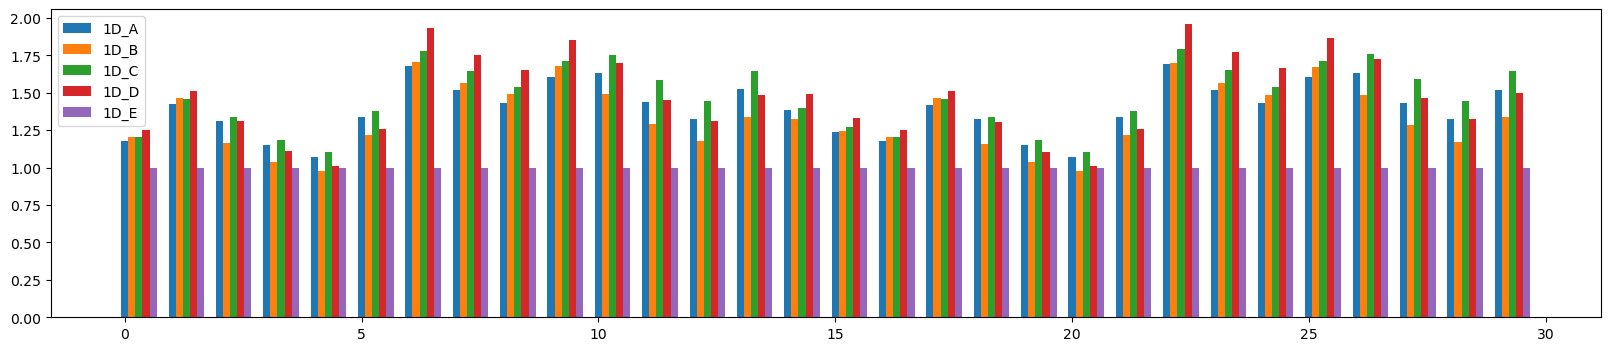

In [32]:
import torch
import numpy as np
import re
import matplotlib.pyplot as plt
def load_data_to_tensor(file_path):
	data_list = []
	with open(file_path, 'r') as file:
		for line in file:
			match = re.search(r'bs=(\d+)\s*, dimX=(\d+)\s*, DY=(\d+)\s*, N=(\d+)\s*, K=(\d+)\s*, TIME=\s*([\d.]+)ms', line)
			if match:
				bs, dimX, DY, N, K, time = map(float, match.groups())
				data_list.append([bs, dimX, DY, N, K, time])
	tensor_data = torch.tensor(data_list, dtype=torch.float32)
	return tensor_data

file_path = [
			'exp_data/1D_A', 
			'exp_data/1D_B', 
			'exp_data/1D_C', 
			'exp_data/1D_D', 
			'exp_data/1D_E']
data = []
plt.figure(figsize=(20, 4))

for file in file_path:
	data.append(load_data_to_tensor(file))
samples =30
x = np.arange(samples)
bar_width=0.15
cnt = 0

for i in range(len(data)):
	performance_ratio =  data[-1][:, -1] / data[0][:, -1]
	plt.bar(x + cnt * bar_width, data[-1][-samples:, -1] / data[i][-samples:, -1], width=bar_width, label=file_path[i][-4:])
	cnt += 1
plt.legend()
plt.savefig('1D.pdf')
# for i in range(1, len(performance_ratio)):
# 	if performance_ratio[i] > 1.6:
# 		print(data[0][i], data[1][i, -1])
# 	# print(performance_ratio[i])

torch.Size([4, 2, 4])
torch.Size([4, 2, 4])
torch.Size([4, 2, 4])
torch.Size([4, 2, 4])
torch.Size([4, 2, 4])


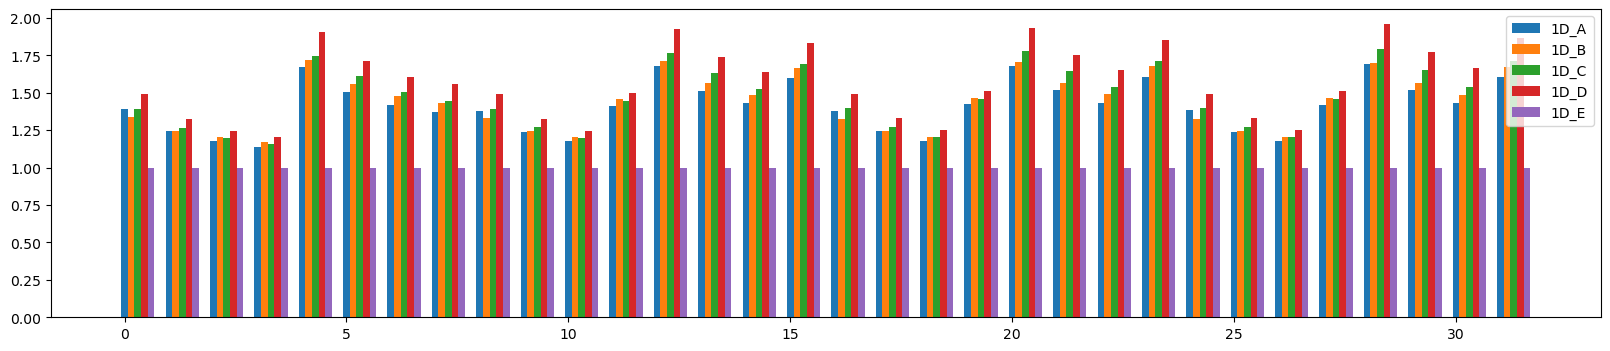

In [ ]:
import torch
import numpy as np
import re
import matplotlib.pyplot as plt


import torch
import re
import numpy as np

def load_data_to_tensor(file_path):
    # 读取数据
    data_list = []

    with open(file_path, 'r') as file:
        for line in file:
            match = re.search(r'bs=(\d+)\s*, dimX=(\d+)\s*, DY=(\d+)\s*, N=(\d+)\s*, K=(\d+)\s*, TIME=\s*([\d.]+)ms', line)
            if match:
                bs, dimX, DY, N, K, time = map(float, match.groups())
                data_list.append([bs, dimX, DY, N, K, time])

    # 转换为 PyTorch Tensor
    data_array = np.array(data_list)  # shape: (N, 6)

    # 提取唯一值，确定 Tensor 形状
    bs_vals = np.unique(data_array[:, 0])
    dimX_vals = np.unique(data_array[:, 1])
    DY_vals = np.unique(data_array[:, 2])
    N_vals = np.unique(data_array[:, 3])
    K_vals = np.unique(data_array[:, 4])

    # 创建 5D Tensor，并初始化为 NaN
    tensor_shape = (len(bs_vals), len(dimX_vals), len(DY_vals), len(N_vals), len(K_vals))
    tensor_data = torch.full(tensor_shape, float('nan'), dtype=torch.float32)

    # 映射参数值到索引
    def get_index(val, arr):
        return np.where(arr == val)[0][0]

    # 填充数据
    for row in data_array:
        bs_idx = get_index(row[0], bs_vals)
        dimX_idx = get_index(row[1], dimX_vals)
        DY_idx = get_index(row[2], DY_vals)
        N_idx = get_index(row[3], N_vals)
        K_idx = get_index(row[4], K_vals)
        tensor_data[bs_idx, dimX_idx, DY_idx, N_idx, K_idx] = row[5]  # 存 TIME

    return tensor_data, bs_vals, dimX_vals, DY_vals, N_vals, K_vals

file_path = [
			'exp_data/1D_A', 
			'exp_data/1D_B', 
			'exp_data/1D_C', 
			'exp_data/1D_D', 
			'exp_data/1D_E']
data = []
plt.figure(figsize=(20, 4))

for file in file_path:
	tensor_data, bs_vals, dimX_vals, DY_vals, N_vals, K_vals = load_data_to_tensor(file)
	data.append(tensor_data)
samples = data[0][-1,  :, :, 0, :].flatten().shape[0]
x = np.arange(samples)
bar_width=0.15
cnt = 0

for i in range(len(data)):
	performance_ratio =  data[-1][-1, :, :, 0, :] / data[i][-1,  :, :, 0, :]
	print(performance_ratio.shape)
	# assert 0
	plt.bar(x + cnt * bar_width, performance_ratio.flatten(), width=bar_width, label=file_path[i][-4:])
	cnt += 1
plt.legend()
plt.savefig('1D.pdf')
# for i in range(1, len(performance_ratio)):
# 	if performance_ratio[i] > 1.6:
# 		print(data[0][i], data[1][i, -1])
# 	# print(performance_ratio[i])

torch.Size([2, 4])
torch.Size([2, 4])
torch.Size([2, 4])
torch.Size([2, 4])
torch.Size([2, 4])


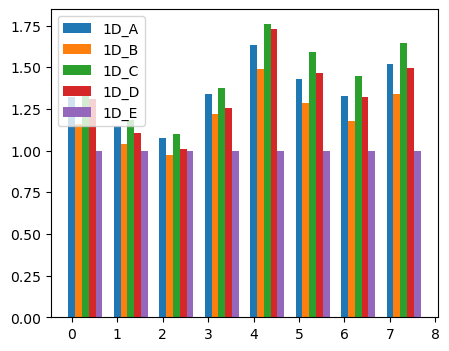

In [48]:
plt.figure(figsize=(5, 4))
samples = data[0][-1,  -1, :, 1, :].flatten().shape[0]
x = np.arange(samples)
bar_width=0.15
cnt = 0

for i in range(len(data)):
	performance_ratio =  data[-1][-1, -1, :, 1, :] / data[i][-1,  -1, :, 1, :]
	print(performance_ratio.shape)
	# assert 0
	plt.bar(x + cnt * bar_width, performance_ratio.flatten(), width=bar_width, label=file_path[i][-4:])
	cnt += 1
plt.legend()
plt.savefig('1D.pdf')

torch.Size([2, 4])
torch.Size([2, 4])
torch.Size([2, 4])
torch.Size([2, 4])
torch.Size([2, 4])


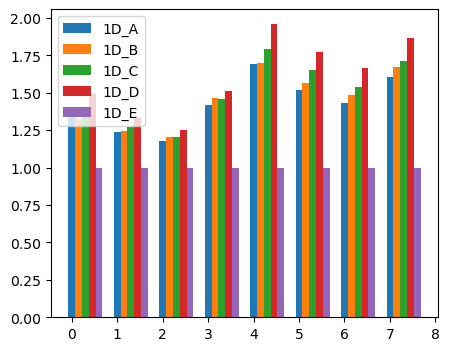

In [49]:
plt.figure(figsize=(5, 4))
samples = data[0][-1,  -1, :, 0, :].flatten().shape[0]
x = np.arange(samples)
bar_width=0.15
cnt = 0

for i in range(len(data)):
	performance_ratio =  data[-1][-1, -1, :, 0, :] / data[i][-1,  -1, :, 0, :]
	print(performance_ratio.shape)
	# assert 0
	plt.bar(x + cnt * bar_width, performance_ratio.flatten(), width=bar_width, label=file_path[i][-4:])
	cnt += 1
plt.legend()
plt.savefig('1D.pdf')

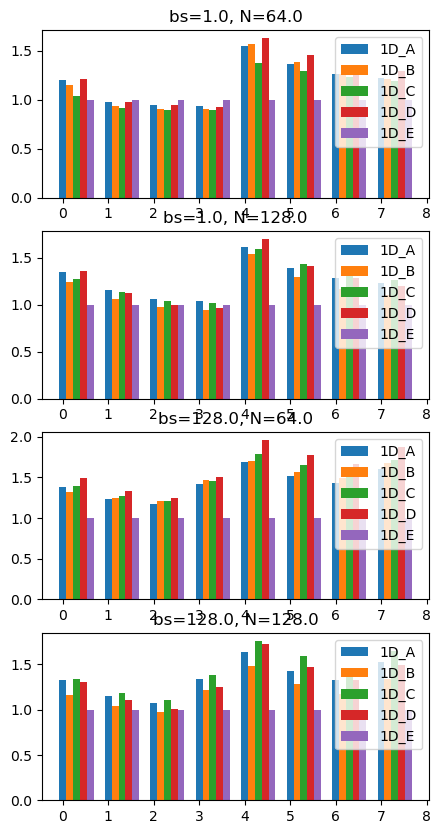

In [55]:
fig, ax = plt.subplots(figsize=(5, 10), nrows = 4)
bs_id = 0
N_id = 0
samples = data[0][bs_id,  -1, :, N_id, :].flatten().shape[0]
x = np.arange(samples)
bar_width=0.15
fig_id = 0
for bs_id in [0, -1]:
	for N_id in [0, -1]:
		cnt = 0
		for i in range(len(data)):
			performance_ratio =  data[-1][bs_id, -1, :, N_id, :] / data[i][bs_id,  -1, :, N_id, :]
			# print(performance_ratio.shape)
			# assert 0
			ax[fig_id].bar(x + cnt * bar_width, performance_ratio.flatten(), width=bar_width, label=file_path[i][-4:])
			cnt += 1
		ax[fig_id].legend()
		ax[fig_id].set_title(f'bs={bs_vals[bs_id]}, N={N_vals[N_id]}')
		fig_id += 1
		# plt.savefig('1D.pdf')